<div class="alert alert-success">
    <h1 align="center">Harmonic Oscillator Physics informed NN</h1>
    <h3 align="center"><a href="https://github.com/msajad79/Harmonic_Oscillator_PINN">Mohammad Sajad Khanbabaei</a></h3>
</div>

### ODE equetion

- $$
\ddot{x} + 2 \zeta \omega_n \dot{x} + \omega^2_n x = 0
$$
- $$
\begin{cases}
x(0) = x_0
\\
\dot{x}(0) = \dot{x}_0
\end{cases}
$$

### ODE Exact Solotion
- for $\zeta < 1$ :

$$x(t) = Xe^{-\zeta\omega_nt}\cos{(\sqrt{1-\zeta^2}\omega_nt-\phi)}$$
$$
\begin{cases}
X = \frac{\sqrt{\omega_n^2x_0^2+\dot{x}^2+2\zeta\omega_nx_0\dot{x}_0}}{\omega_n\sqrt{1-\zeta^2}}
\\
\phi = \tan^{-1}{\frac{\dot{x}_0 + \zeta \omega_n x_0}{x_0 \omega_n \sqrt{1-\zeta^2}}}
\end{cases}
$$

- for $\zeta > 1$ :
$$
x(t) = C_1 e^{(-\zeta+\sqrt{\zeta^2-1})\omega_n t} + C_2 e^{(-\zeta-\sqrt{\zeta^2-1})\omega_n t}
$$
$$
\begin{cases}
C_1 = \frac{x_0 \omega_n (\zeta+\sqrt{\zeta^2-1}) + \dot{x}_0}{2\omega_n \sqrt{\zeta^2-1}}
\\
C_2 = \frac{-x_0 \omega_n (\zeta-\sqrt{\zeta^2-1}) - \dot{x}_0}{2\omega_n \sqrt{\zeta^2-1}}
\end{cases}
$$

- for $\zeta = 1$ :
$$
x(t) = (C_1 + C_2 t) e^{-\omega_n t}
$$
$$
\begin{cases}
C_1 = x_0
\\
C_2 = \dot{x}_0 + x_0 \omega_n
\end{cases}
$$

# imports

In [1]:
%load_ext tensorboard

import time
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch import nn, optim
from losses import OscillationLoss
from dataprocess import DataLoader, LabeledDataset, PhysicsDataset
from models import FCN
from utils import oscillation, plot_pred_exact_oscillation, plot_lbl_data, calc_error


# problem with spesific $\omega_n, \zeta, x_0, \dot{x}_0$

In [2]:
# setup program
torch.manual_seed(123)
writer = SummaryWriter()
device = torch.device("cpu")

In [3]:
# setup basic params
wn_s=torch.tensor([10.0])
zeta_s=torch.tensor([0.5]) 
x0_s=torch.tensor([1.0])
xdot0_s=torch.tensor([0.0])

In [4]:
# data process
def data_process(wn_s:torch.tensor, zeta_s:torch.tensor, x0_s:torch.tensor, xdot0_s:torch.tensor):
    train_lbl_ds = LabeledDataset(
        t_s=torch.linspace(0,.5,10), 
        wn_s=wn_s,
        zeta_s=zeta_s, 
        x0_s=x0_s, 
        xdot0_s=xdot0_s,
        device=device
    )
    train_phy_ds = PhysicsDataset(
        t_s=torch.linspace(0,1,20), 
        wn_s=wn_s,
        zeta_s=zeta_s, 
        x0_s=x0_s, 
        xdot0_s=xdot0_s,
        device=device
    )
    train_lbl_dl = DataLoader(train_lbl_ds, batch_size=len(train_lbl_ds), shuffle=True)
    train_phy_dl = DataLoader(train_phy_ds, batch_size=len(train_phy_ds), shuffle=True)

    test_lbl_ds = LabeledDataset(
        t_s=torch.linspace(0,1,5), 
        wn_s=torch.tensor([10.0]), 
        zeta_s=torch.tensor([0.5]), 
        x0_s=torch.tensor([1.0]), 
        xdot0_s=torch.tensor([0.0]),
        device=device
    )
    test_phy_ds = PhysicsDataset(
        t_s=torch.linspace(0,1,100), 
        wn_s=torch.tensor([10.0]), 
        zeta_s=torch.tensor([0.5]), 
        x0_s=torch.tensor([1.0]), 
        xdot0_s=torch.tensor([0.0]),
        device=device
    )
    test_lbl_dl = DataLoader(test_lbl_ds, batch_size=len(test_lbl_ds), shuffle=True)
    test_phy_dl = DataLoader(test_phy_ds, batch_size=len(test_phy_ds), shuffle=True)
    return train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl
train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl = data_process(
    wn_s=wn_s,
    zeta_s=zeta_s, 
    x0_s=x0_s, 
    xdot0_s=xdot0_s,
)

In [10]:
# setup model
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=4).to(device)
#model = torch.load("./models/model_28_8_9_1_sajad.pt")
criterion = OscillationLoss(
    lambda_lbl=torch.tensor(1.0e4),
    lambda_IC_x0=torch.tensor(1.0e4),
    lambda_IC_xdot0=torch.tensor(1.0),
    lambda_GvEq=torch.tensor(1.0),
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=350, gamma=.9)

In [11]:
# train
epochs = 10000
MIN_LOSS_GVEQ = 0.01
for epoch in (pbar := tqdm(range(epochs))):
    # get data
    inp_train_lbl, target_train_lbl = next(iter(train_lbl_dl))
    inp_train_phy = next(iter(train_phy_dl))

    # forward
    out_lbl = model(inp_train_lbl[:,[0]]) # just send t for model
    out_phy = model(inp_train_phy[:,[0]]) # just send t for model
    
    # loss
    loss = criterion(inp_train_lbl, target_train_lbl, out_lbl, inp_train_phy, out_phy)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # pbar log
    pbar.set_description(f"loss : {loss.item()}, lr:{scheduler.get_last_lr()[0]}")

    # TensorBoard
    writer.add_scalars("loss/train", {
            "loss lbl":criterion.loss_lbl, 
            "loss IC x0":criterion.loss_IC_x0, 
            "loss IX xdot0":criterion.loss_IC_xdot0, 
            "loss GvEq":criterion.loss_GvEq
        }, epoch)
    writer.add_scalars("losslambda/train", {
            "loss lbl":criterion.loss_lbl*criterion.lambda_lbl, 
            "loss IC x0":criterion.loss_IC_x0*criterion.lambda_IC_x0, 
            "loss IX xdot0":criterion.loss_IC_xdot0*criterion.lambda_IC_xdot0, 
            "loss GvEq":criterion.loss_GvEq*criterion.lambda_GvEq
        }, epoch)
    
    # validation
    if epoch % 200 == 0:
        model.eval()

        # predict physics test data
        #inp_test_phy = next(iter(test_phy_dl))
        #out_phy_test = model(inp_test_phy[:, [0,2]]) # just send t for model

        # plot pred and exact solution physics test data
        #fig, ax = plt.subplots(1, figsize=(7, 7))
        #fig, ax = plot_pred_exact_oscillation(inp_phy=inp_test_phy, out_phy=out_phy_test, fig=fig, ax=ax)
        #writer.add_figure("plot_pred_exact_oscillation/test", fig, epoch)

        # plot last train data
        fig, ax = plt.subplots(1, figsize=(10, 10))
        fig, ax = plot_pred_exact_oscillation(inp_phy=inp_train_phy, out_phy=out_phy, fig=fig, ax=ax)
        fig, ax = plot_lbl_data(inp_lbl=inp_train_lbl, target_lbl=target_train_lbl, fig=fig, ax=ax)
        writer.add_figure("plot_pred_exact_oscillation/train", fig, epoch)


        model.train()
    
    if criterion.loss_GvEq.item() < MIN_LOSS_GVEQ and s != 20 and epoch > 400 and False:
        s+=1
        train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl = data_process(s)

    scheduler.step()


loss : 0.11008046567


# problem with spesific $\zeta, x_0, \dot{x}_0$ and variable $\omega_n$

In [2]:
# setup program
torch.manual_seed(123)
writer = SummaryWriter()
device = torch.device("cpu")

In [3]:
# setup basic params
wn_s=torch.linspace(5.0, 20.0, 4)
zeta_s=torch.tensor([0.5]) 
x0_s=torch.tensor([1.0])
xdot0_s=torch.tensor([0.0])

In [5]:
# data process
def data_process(wn_s:torch.tensor, zeta_s:torch.tensor, x0_s:torch.tensor, xdot0_s:torch.tensor):
    train_lbl_ds = LabeledDataset(
        t_s=torch.linspace(0,.5,10), 
        wn_s=wn_s,
        zeta_s=zeta_s, 
        x0_s=x0_s, 
        xdot0_s=xdot0_s,
        device=device
    )
    train_phy_ds = PhysicsDataset(
        t_s=torch.linspace(0,1,20), 
        wn_s=wn_s,
        zeta_s=zeta_s, 
        x0_s=x0_s, 
        xdot0_s=xdot0_s,
        device=device
    )
    train_lbl_dl = DataLoader(train_lbl_ds, batch_size=len(train_lbl_ds), shuffle=True)
    train_phy_dl = DataLoader(train_phy_ds, batch_size=len(train_phy_ds), shuffle=True)

    test_lbl_ds = LabeledDataset(
        t_s=torch.linspace(0,1,5), 
        wn_s=torch.tensor([10.0]), 
        zeta_s=torch.tensor([0.5]), 
        x0_s=torch.tensor([1.0]), 
        xdot0_s=torch.tensor([0.0]),
        device=device
    )
    test_phy_ds = PhysicsDataset(
        t_s=torch.linspace(0,1,100), 
        wn_s=torch.linspace(5.0,20.0,8),
        zeta_s=torch.tensor([0.5]), 
        x0_s=torch.tensor([1.0]), 
        xdot0_s=torch.tensor([0.0]),
        device=device
    )
    test_lbl_dl = DataLoader(test_lbl_ds, batch_size=len(test_lbl_ds), shuffle=True)
    test_phy_dl = DataLoader(test_phy_ds, batch_size=len(test_phy_ds), shuffle=True)
    return train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl
train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl = data_process(
    wn_s=wn_s,
    zeta_s=zeta_s, 
    x0_s=x0_s, 
    xdot0_s=xdot0_s,
)

In [6]:
# setup model
model = FCN(N_INPUT=2, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=4).to(device)
#model = torch.load("./models/model_28_8_9_1_sajad.pt")
criterion = OscillationLoss(
    lambda_lbl=torch.tensor(1.0e4),
    lambda_IC_x0=torch.tensor(1.0e4),
    lambda_IC_xdot0=torch.tensor(1.0),
    lambda_GvEq=torch.tensor(1.0),
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=.9)

In [9]:
# train
epochs = 10000
MIN_LOSS_GVEQ = 0.01
for epoch in (pbar := tqdm(range(epochs))):
    # get data
    inp_train_lbl, target_train_lbl = next(iter(train_lbl_dl))
    inp_train_phy = next(iter(train_phy_dl))

    # forward
    out_lbl = model(inp_train_lbl[:,[0,2]]) # just send t, wn for model
    out_phy = model(inp_train_phy[:,[0,2]]) # just send t, wn for model
    
    # loss
    loss = criterion(inp_train_lbl, target_train_lbl, out_lbl, inp_train_phy, out_phy)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # pbar log
    pbar.set_description(f"loss : {loss.item()} lr:{scheduler.get_last_lr()[0]}")

    # TensorBoard
    writer.add_scalars("loss/train", {
            "loss lbl":criterion.loss_lbl, 
            "loss IC x0":criterion.loss_IC_x0, 
            "loss IX xdot0":criterion.loss_IC_xdot0, 
            "loss GvEq":criterion.loss_GvEq
        }, epoch)
    writer.add_scalars("losslambda/train", {
            "loss lbl":criterion.loss_lbl*criterion.lambda_lbl, 
            "loss IC x0":criterion.loss_IC_x0*criterion.lambda_IC_x0, 
            "loss IX xdot0":criterion.loss_IC_xdot0*criterion.lambda_IC_xdot0, 
            "loss GvEq":criterion.loss_GvEq*criterion.lambda_GvEq
        }, epoch)
    
    # validation
    if epoch % 200 == 0:
        model.eval()

        # predict physics test data
        inp_test_phy = next(iter(test_phy_dl))
        out_phy_test = model(inp_test_phy[:, [0,2]]) # just send t, wn for model

        # calc error test data
        df_error_test = calc_error(inp_phy=inp_test_phy, out_phy=out_phy_test)

        # plot wn error
        fig, ax = plt.subplots(1, figsize=(7, 7))
        ax.plot(df_error_test['wn'], df_error_test['error'])
        for wn_train in inp_train_phy[:,2].unique():
            plt.axvline(x=wn_train.detach(), color='red', linestyle='--')
        writer.add_figure("plot_error_wn/test", fig, epoch)
        
        # plot pred and exact solution physics test data
        fig, ax = plt.subplots(1, figsize=(7, 7))
        fig, ax = plot_pred_exact_oscillation(inp_phy=inp_test_phy, out_phy=out_phy_test, fig=fig, ax=ax)
        writer.add_figure("plot_pred_exact_oscillation/test", fig, epoch)

        # plot last train data
        fig, ax = plt.subplots(1, figsize=(10, 10))
        fig, ax = plot_pred_exact_oscillation(inp_phy=inp_train_phy, out_phy=out_phy, fig=fig, ax=ax)
        fig, ax = plot_lbl_data(inp_lbl=inp_train_lbl, target_lbl=target_train_lbl, fig=fig, ax=ax)
        writer.add_figure("plot_pred_exact_oscillation/train", fig, epoch)


        model.train()
    
    if criterion.loss_GvEq.item() < MIN_LOSS_GVEQ and s != 20 and epoch > 400 and False:
        s+=1
        train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl = data_process(s)

    scheduler.step()


loss : 0.13449712097


# problem with spesific $x_0, \dot{x}_0$ and variable $\omega_n, \zeta$

In [2]:
# setup program
torch.manual_seed(123)
writer = SummaryWriter()
device = torch.device("cpu")

In [4]:
# setup basic params
wn_s=torch.linspace(5.0, 20.0, 4)
zeta_s=torch.linspace(0.5,1.5, 4)
x0_s=torch.tensor([1.0])
xdot0_s=torch.tensor([0.0])

wn_s_phy=torch.linspace(3.0, 25.0, 8)
zeta_s_phy=torch.linspace(0.3,2.5, 8)
x0_s_phy=torch.tensor([1.0])
xdot0_s_phy=torch.tensor([0.0])

In [5]:
# data process
def data_process(
        wn_s:torch.tensor, zeta_s:torch.tensor, x0_s:torch.tensor, xdot0_s:torch.tensor,
        wn_s_phy:torch.tensor, zeta_s_phy:torch.tensor, x0_s_phy:torch.tensor, xdot0_s_phy:torch.tensor
    ):
    train_lbl_ds = LabeledDataset(
        t_s=torch.linspace(0,.5,10), 
        wn_s=wn_s,
        zeta_s=zeta_s, 
        x0_s=x0_s, 
        xdot0_s=xdot0_s,
        device=device
    )
    train_phy_ds = PhysicsDataset(
        t_s=torch.linspace(0,1,20), 
        wn_s=wn_s_phy,
        zeta_s=zeta_s_phy, 
        x0_s=x0_s_phy, 
        xdot0_s=xdot0_s_phy,
        device=device
    )
    train_lbl_dl = DataLoader(train_lbl_ds, batch_size=len(train_lbl_ds), shuffle=True)
    train_phy_dl = DataLoader(train_phy_ds, batch_size=len(train_phy_ds), shuffle=True)

    test_lbl_ds = LabeledDataset(
        t_s=torch.linspace(0,1,5), 
        wn_s=torch.tensor([10.0]), 
        zeta_s=torch.tensor([0.5]), 
        x0_s=torch.tensor([1.0]), 
        xdot0_s=torch.tensor([0.0]),
        device=device
    )
    test_phy_ds = PhysicsDataset(
        t_s=torch.linspace(0,1,50), 
        wn_s=torch.linspace(.2,28.0,8),
        zeta_s=torch.linspace(.2,3.8,8), 
        x0_s=torch.tensor([1.0]), 
        xdot0_s=torch.tensor([0.0]),
        device=device
    )
    test_lbl_dl = DataLoader(test_lbl_ds, batch_size=len(test_lbl_ds), shuffle=True)
    test_phy_dl = DataLoader(test_phy_ds, batch_size=len(test_phy_ds), shuffle=True)
    return train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl
train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl = data_process(
    wn_s=wn_s,
    zeta_s=zeta_s, 
    x0_s=x0_s, 
    xdot0_s=xdot0_s,
    wn_s_phy=wn_s_phy,
    zeta_s_phy=zeta_s_phy, 
    x0_s_phy=x0_s_phy, 
    xdot0_s_phy=xdot0_s_phy,
)

In [6]:
# setup model
model = FCN(N_INPUT=3, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=4).to(device)
#model = torch.load("./models/model_28_8_9_1_sajad.pt")
criterion = OscillationLoss(
    lambda_lbl=torch.tensor(1.0e4),
    lambda_IC_x0=torch.tensor(1.0e4),
    lambda_IC_xdot0=torch.tensor(1.0),
    lambda_GvEq=torch.tensor(1.0),
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=.9)

In [ ]:
# train
epochs = 10000
MIN_LOSS_GVEQ = 0.01
for epoch in (pbar := tqdm(range(epochs))):
    # get data
    inp_train_lbl, target_train_lbl = next(iter(train_lbl_dl))
    inp_train_phy = next(iter(train_phy_dl))

    # forward
    out_lbl = model(inp_train_lbl[:,[0,1,2]]) # just send t, zeta, wn for model
    out_phy = model(inp_train_phy[:,[0,1,2]]) # just send t, zeta, wn for model
    
    # loss
    loss = criterion(inp_train_lbl, target_train_lbl, out_lbl, inp_train_phy, out_phy)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # pbar log
    pbar.set_description(f"loss : {loss.item()} lr:{scheduler.get_last_lr()[0]}")

    # TensorBoard
    writer.add_scalars("loss/train", {
            "loss lbl":criterion.loss_lbl, 
            "loss IC x0":criterion.loss_IC_x0, 
            "loss IX xdot0":criterion.loss_IC_xdot0, 
            "loss GvEq":criterion.loss_GvEq
        }, epoch)
    writer.add_scalars("losslambda/train", {
            "loss lbl":criterion.loss_lbl*criterion.lambda_lbl, 
            "loss IC x0":criterion.loss_IC_x0*criterion.lambda_IC_x0, 
            "loss IX xdot0":criterion.loss_IC_xdot0*criterion.lambda_IC_xdot0, 
            "loss GvEq":criterion.loss_GvEq*criterion.lambda_GvEq
        }, epoch)
    
    # validation
    if epoch % 200 == 0:
        model.eval()

        # predict physics test data
        inp_test_phy = next(iter(test_phy_dl))
        out_phy_test = model(inp_test_phy[:, [0,1,2]]) # just send t, zeta, wn for model

        # calc error test data
        df_error_test = calc_error(inp_phy=inp_test_phy, out_phy=out_phy_test)

        # plot wn error
        df_wn = df_error_test.groupby(['wn']).sum()
        fig, ax = plt.subplots(1, figsize=(7, 7))
        ax.plot(df_wn.index, df_wn['error'])
        for wn_train in inp_train_phy[:,2].unique():
            plt.axvline(x=wn_train.detach(), color='red', linestyle='--')
        for wn_train_lbl in inp_train_lbl[:,2].unique():
            plt.axvline(x=wn_train_lbl.detach(), color='green', linestyle='--')
        writer.add_figure("plot_error_wn/test", fig, epoch)

        # plot zeta error 
        df_zeta = df_error_test.groupby(['zeta']).sum()
        fig, ax = plt.subplots(1, figsize=(7, 7))
        ax.plot(df_zeta.index, df_zeta['error'])
        for zeta_train_phy in inp_train_phy[:,1].unique():
            plt.axvline(x=zeta_train_phy.detach(), color='red', linestyle='--')
        for zeta_train_lbl in inp_train_lbl[:,1].unique():
            plt.axvline(x=zeta_train_lbl.detach(), color='green', linestyle='--')
        writer.add_figure("plot_error_zeta/test", fig, epoch)
        
        # plot pred and exact solution physics test data
        fig, ax = plt.subplots(1, figsize=(7, 7))
        fig, ax = plot_pred_exact_oscillation(inp_phy=inp_test_phy, out_phy=out_phy_test, fig=fig, ax=ax)
        writer.add_figure("plot_pred_exact_oscillation/test", fig, epoch)

        # plot last train data
        fig, ax = plt.subplots(1, figsize=(7, 7))
        fig, ax = plot_pred_exact_oscillation(inp_phy=inp_train_phy, out_phy=out_phy, fig=fig, ax=ax)
        fig, ax = plot_lbl_data(inp_lbl=inp_train_lbl, target_lbl=target_train_lbl, fig=fig, ax=ax)
        writer.add_figure("plot_pred_exact_oscillation/train", fig, epoch)


        model.train()
    
    if criterion.loss_GvEq.item() < MIN_LOSS_GVEQ and s != 20 and epoch > 400 and False:
        s+=1
        train_lbl_ds, train_lbl_dl, train_phy_ds, train_phy_dl, test_lbl_ds, test_lbl_dl, test_phy_ds, test_phy_dl = data_process(s)

    scheduler.step()


loss : 11.330507278442383 lr:0.00020589113209464906:  76%|▊| 7583/10000 [

In [21]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib qt 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# داده‌ها
x = df_error_test['zeta']
y = df_error_test['wn']
z = df_error_test['error']  # احتمالا باید df_error_test['zeta'] اینجا را df_error_test['zeta'] یا df_error_test['zeta2'] تغییر دهید


# scatter plot
ax.scatter(x, y, (z), c=z, marker='o')
ax.set_xlabel("zeta")
ax.set_ylabel("wn")
ax.set_zlabel("error")
plt.show()

In [18]:

        inp_test_phy = next(iter(test_phy_dl))
        out_phy_test = model(inp_test_phy[:, [0,1,2]]) # just send t, zeta, wn for model

In [19]:

        df_error_test = calc_error(inp_phy=inp_test_phy, out_phy=out_phy_test)

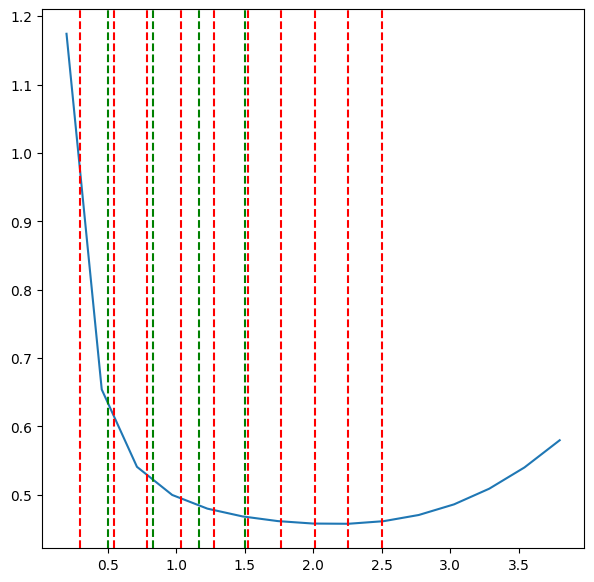

In [29]:

        df_zeta = df_error_test.groupby(['zeta']).sum()
        fig, ax = plt.subplots(1, figsize=(7, 7))
        ax.plot(df_zeta.index, df_zeta['error'])
        for zeta_train_phy in inp_train_phy[:,1].unique():
            plt.axvline(x=zeta_train_phy.detach(), color='red', linestyle='--')
        for zeta_train_lbl in inp_train_lbl[:,1].unique():
            plt.axvline(x=zeta_train_lbl.detach(), color='green', linestyle='--')

Index([0.20000000298023224,  2.1857142448425293,   4.171428203582764,
         6.157142639160156,    8.14285659790039,  10.128570556640625,
        12.114285469055176,  14.100000381469727,   16.08571434020996,
        18.071430206298828,  20.057144165039062,  22.042858123779297,
         24.02857208251953,  26.014286041259766,                28.0],
      dtype='float64', name='wn')